In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch

# a)

In [2]:
df = pd.read_csv("./Data/HW2_data/international_matches.csv")
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# b)

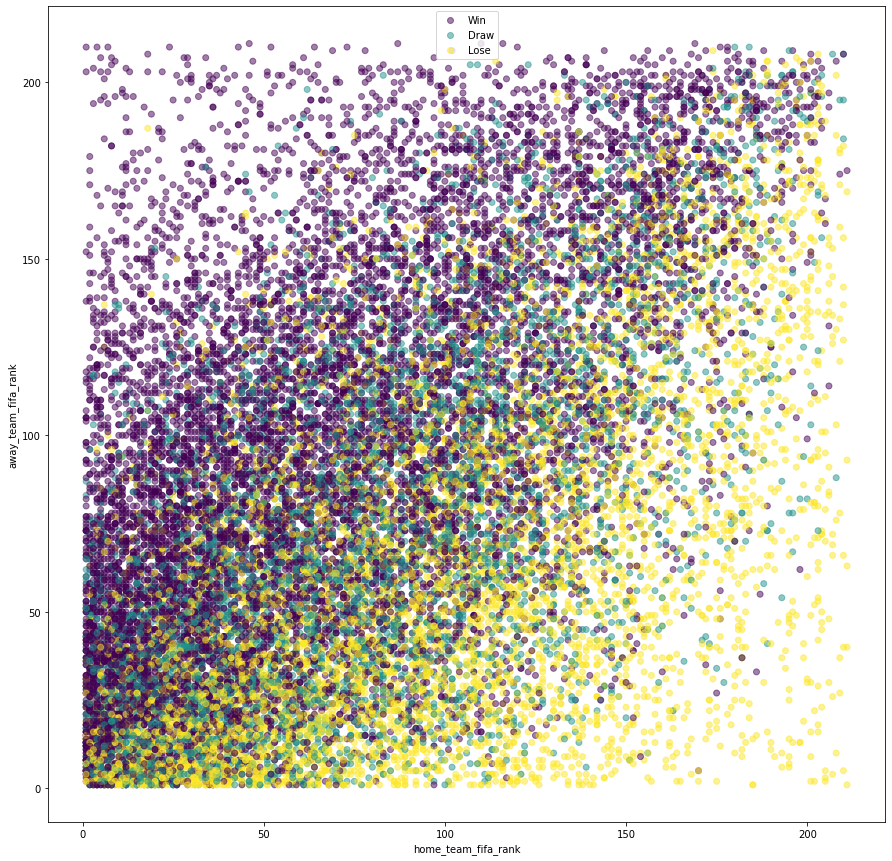

In [3]:
plt.figure(figsize=(15, 15))
scatter = plt.scatter(df.home_team_fifa_rank, df.away_team_fifa_rank, 
            c=df.home_team_result.replace(df.home_team_result.unique(), [0, 1, 2]), 
            alpha=0.5)
plt.xlabel("home_team_fifa_rank")
plt.ylabel("away_team_fifa_rank")
plt.legend(handles=scatter.legend_elements()[0], labels=list(df.home_team_result.unique()))
plt.show()

# C)

In [4]:
df = df.loc[df.away_team_total_fifa_points != 0]
df = df.loc[df.home_team_total_fifa_points != 0]

In [5]:
X = df[["away_team_fifa_rank", "home_team_fifa_rank", "home_team_total_fifa_points", "away_team_total_fifa_points"]]
y = df.home_team_result

# d)

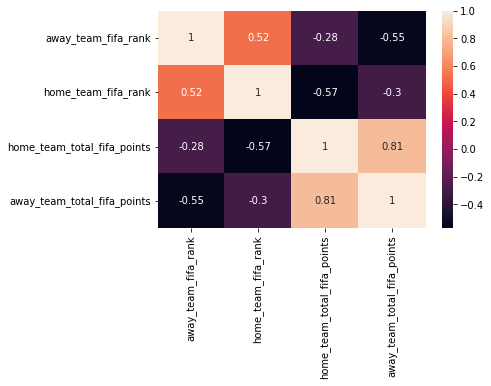

In [6]:
plt.figure()
sns.heatmap(X.corr(), annot=True)
plt.show()

# C)
Train-Test Split

In [7]:
X = df[["away_team_fifa_rank", "home_team_fifa_rank", "home_team_total_fifa_points", "away_team_total_fifa_points"]]
X = X.to_numpy()
y = df.home_team_result.replace(df.home_team_result.unique(), [0, 1, 2])
y = y.to_numpy()

In [8]:
n_samples = X.shape[0]
permuation = np.arange(n_samples)
np.random.shuffle(permuation)

X = X[permuation]
y = y[permuation]

train_percentage = 0.75
n_train = int(train_percentage * n_samples)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

train_data = TensorDataset(torch.Tensor(X_train).type(torch.torch.FloatTensor), torch.Tensor(y_train).type(torch.torch.LongTensor))
test_data = TensorDataset(torch.Tensor(X_test).type(torch.torch.FloatTensor), torch.Tensor(y_test).type(torch.torch.LongTensor))

# e)

In [9]:
class MyNet(nn.Module):
    def __init__(self, input_size, criterion=nn.CrossEntropyLoss(), lr=1e-3):
        super(MyNet, self).__init__()

        self.criterion = criterion
        self.model = nn.Sequential(*[
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        ])
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
    def forward(self, xb):
        return self.model(xb)
    
    def calculate_accuracy(self, outputs, true_labels):
        predicted = torch.argmax(outputs, dim=-1)
        accuracy = torch.sum(predicted == true_labels) / true_labels.shape[0]
        return accuracy.item()
    
    def evaluate(self, evaluation_data, batch_size):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data, batch_size=batch_size, shuffle=False)
        x, y = iter(evaluation_loader).next()

        with torch.no_grad():
          outputs = self.model(x)
          loss = self.criterion(outputs, y).item()
          accuracy = self.calculate_accuracy(outputs, y)

        return accuracy, loss

    def fit(self, train_data, test_data, batch_size=64, n_epoch=12):
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        train_acc = []
        test_acc = []
        train_loss = []
        test_loss = []

        self.train()
        for epoch in range(n_epoch):
            for _, data in enumerate(train_loader):
                xb, yb = data[0], data[1]
                output = self.model(xb)
                self.optimizer.zero_grad()
                loss = self.criterion(output, yb)
                loss.backward() 
                self.optimizer.step()
            
            train_acc_epoch, train_loss_epoch = self.evaluate(train_data, len(train_data))
            test_acc_epoch, test_loss_epoch = self.evaluate(test_data, len(test_data))
            train_acc.append(train_acc_epoch)
            train_loss.append(train_loss_epoch)
            test_acc.append(test_acc_epoch)
            test_loss.append(test_loss_epoch)
            print(f"Epoch #{epoch}: training_accuracy={round(train_acc_epoch*100, 2)}%, test_accuracy={round(test_acc_epoch*100, 2)}%, training_loss={round(train_loss_epoch, 2)}, test_loss={round(test_loss_epoch, 2)}")

        return test_acc, test_loss, train_acc, test_acc

In [10]:
n_epoch = 16
batch_size = 128

In [11]:
net = MyNet(4, lr=1e-3)
test_acc, test_loss, train_acc, test_acc = net.fit(train_data, test_data, batch_size=batch_size, n_epoch=n_epoch)

Epoch #0: training_accuracy=40.76%, test_accuracy=41.02%, training_loss=1.14, test_loss=1.13
Epoch #1: training_accuracy=51.34%, test_accuracy=52.31%, training_loss=1.0, test_loss=0.99
Epoch #2: training_accuracy=52.62%, test_accuracy=53.36%, training_loss=0.98, test_loss=0.97
Epoch #3: training_accuracy=52.98%, test_accuracy=53.31%, training_loss=0.96, test_loss=0.96
Epoch #4: training_accuracy=50.13%, test_accuracy=48.56%, training_loss=0.99, test_loss=0.99
Epoch #5: training_accuracy=56.12%, test_accuracy=56.73%, training_loss=0.97, test_loss=0.96
Epoch #6: training_accuracy=55.05%, test_accuracy=55.44%, training_loss=0.96, test_loss=0.95
Epoch #7: training_accuracy=56.72%, test_accuracy=57.9%, training_loss=0.94, test_loss=0.93
Epoch #8: training_accuracy=56.54%, test_accuracy=57.02%, training_loss=0.94, test_loss=0.93
Epoch #9: training_accuracy=55.02%, test_accuracy=54.98%, training_loss=0.95, test_loss=0.94
Epoch #10: training_accuracy=56.03%, test_accuracy=57.52%, training_loss

In [15]:
england_ranking = 5
wales_ranking = 19
usa_ranking = 16
iran_ranking = 20

england_tpts = 1728.47
wales_tpts = 1569.82
usa_tpts = 1627.48
iran_tpts = 1564.61

Iran playing at home:

In [23]:
games = torch.tensor(np.array([
    [england_ranking, iran_ranking, iran_tpts, england_tpts],
    [wales_ranking, iran_ranking, iran_tpts, wales_tpts],
    [usa_ranking, iran_ranking, iran_tpts, usa_tpts]
]))

predicted = torch.argmax(net.model(games.float()), dim=-1)
tmp = df.home_team_result.unique()
print(f"Iran-England: {tmp[predicted[0]]}")
print(f"Iran-Wales: {tmp[predicted[1]]}")
print(f"Iran-USA: {tmp[predicted[2]]}")

Iran-England: Lose
Iran-Wales: Win
Iran-USA: Draw


Iran playing away:

In [28]:
games = torch.tensor(np.array([
    [iran_ranking, england_ranking, england_tpts, iran_tpts],
    [iran_ranking, wales_ranking, wales_tpts, iran_tpts],
    [iran_ranking, usa_ranking, usa_tpts, iran_tpts]
]))

predicted = torch.argmax(net.model(games.float()), dim=-1)
tmp = df.home_team_result.unique()

print(f"Iran-England: {tmp[-predicted[0] + 2]}")
print(f"Iran-Wales: {tmp[-predicted[1] + 2]}")
print(f"Iran-USA: {tmp[-predicted[2] + 2]}")

Iran-England: Lose
Iran-Wales: Lose
Iran-USA: Lose
